In [1]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
except ValueError:
    tpu = None
    print("Not connected to a TPU runtime")

if tpu:

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)


Running on TPU: 
Number of replicas: 8


## Step 1. Preparing Dataset


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

# Splitting tf_flowers into train, validation, test
(train_data, val_data, test_data), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

print(ds_info)
print("Train data size:", len(list(train_data)))
print("Validation data size:", len(list(val_data)))
print("Test data size:", len(list(test_data)))


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.99OODT_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/exa

## Step 2. Preprocessing


In [ ]:
IMG_SIZE = 160

def format_example(image, label):
    # Convert image to float32 and scale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = train_data.map(format_example)
val = val_data.map(format_example)
test = test_data.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Checking a sample batch
for image_batch, label_batch in train_batches.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 160, 160, 3)
Label batch shape: (32,)


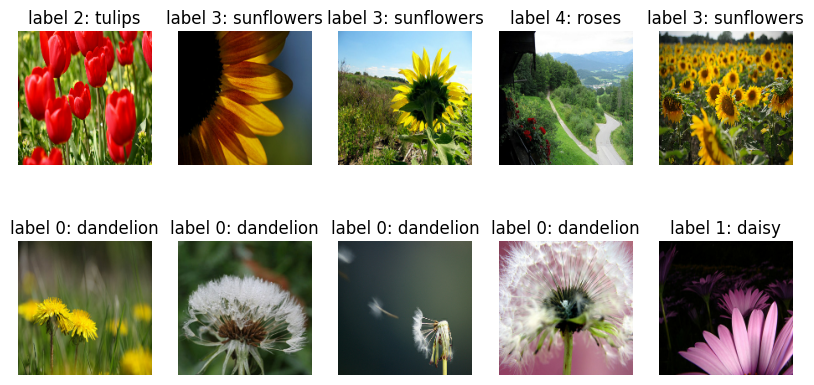

In [ ]:
plt.figure(figsize=(10, 5))


get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 3. Model Design


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = tf.keras.applications.VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Pretrained 모델의 학습 동결 (Freeze the pretrained model)
base_model.trainable = False

# GlobalAveragePooling2D 레이어 준비
# Prepare the global average pooling layer
global_avg_layer = GlobalAveragePooling2D()

# Final classification layer for 5 classes
prediction_layer = Dense(5, activation='softmax')

# Build the full model
model = Sequential([
    base_model,
    global_avg_layer,
    Dense(512, activation='relu'),
    prediction_layer
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(val_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.1398 - loss: 1.8957
initial loss: 1.87
initial accuracy: 0.16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Step 4. Model Training

In [ ]:

EPOCHS = 10

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.3426 - loss: 1.5340 - val_accuracy: 0.6485 - val_loss: 1.1803
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.6810 - loss: 1.1228 - val_accuracy: 0.7003 - val_loss: 0.9195
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.7331 - loss: 0.9060 - val_accuracy: 0.7330 - val_loss: 0.7990
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7736 - loss: 0.7701 - val_accuracy: 0.7411 - val_loss: 0.7169
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.7975 - loss: 0.6777 - val_accuracy: 0.7657 - val_loss: 0.6662
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.7929 - loss: 0.6586 - val_accuracy: 0.7738 - val_loss: 0.6319
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.8208 - loss: 0.5944 - val_accuracy: 0.7820 - val_loss: 0.6171
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8211 - loss: 0.5758 - val_accu

## Step 5. Evaluation & Visualization


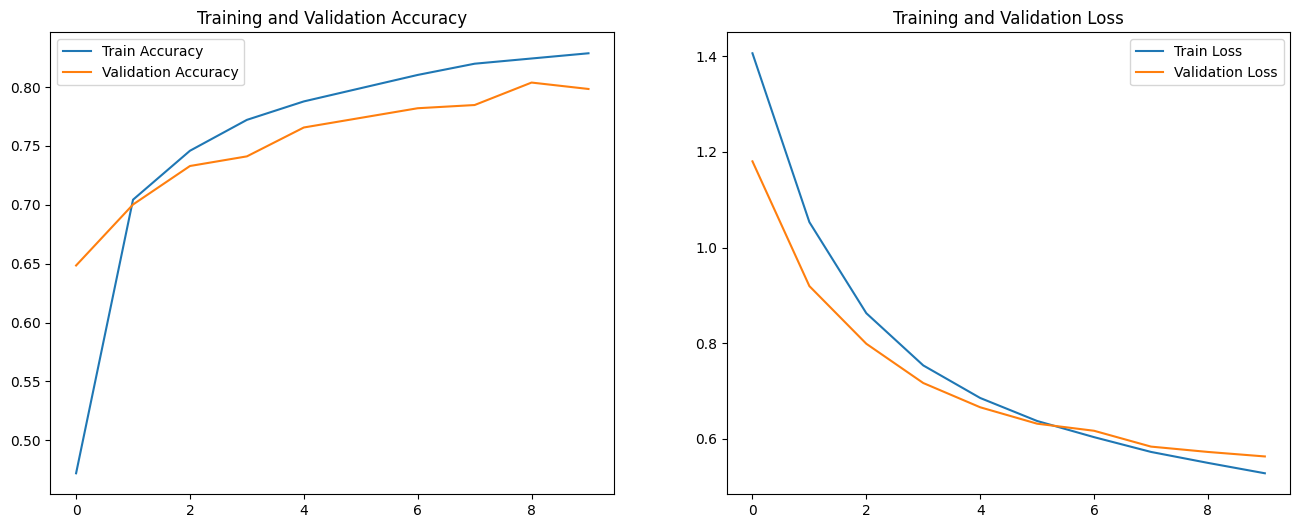

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8135 - loss: 0.5699
Test Loss: 0.5497, Test Accuracy: 0.8256


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[3.33738178e-02, 7.17829391e-02, 6.53970897e-01, 8.25875923e-02,
        1.58284754e-01],
       [9.97632623e-01, 1.78458274e-03, 2.61540299e-05, 2.47832242e-04,
        3.08724731e-04],
       [7.84445703e-01, 8.97116065e-02, 2.12103855e-02, 8.15989450e-02,
        2.30333600e-02],
       [6.38166163e-03, 2.59702578e-02, 4.33281630e-01, 1.80553533e-02,
        5.16311049e-01],
       [7.04113603e-01, 2.29272604e-01, 1.77449025e-02, 2.13059392e-02,
        2.75629815e-02],
       [9.10168231e-01, 5.10900617e-02, 7.52487686e-03, 2.73864921e-02,
        3.83039634e-03],
       [1.60428267e-02, 2.15061251e-02, 6.77536249e-01, 1.95329145e-01,
        8.95857066e-02],
       [4.47873026e-01, 3.82957101e-01, 1.97366276e-03, 1.59174621e-01,
        8.02159309e-03],
       [1.48270885e-02, 2.28610239e-03, 2.65642051e-02, 8.59025896e-01,
        9.72966477e-02],
       [9.98509228e-01, 1.27161329e-03, 3.91569392e-06, 1.99755639e-04,
        1.55256002e-05],
       [9.63330626e-01, 2.7351

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 0, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

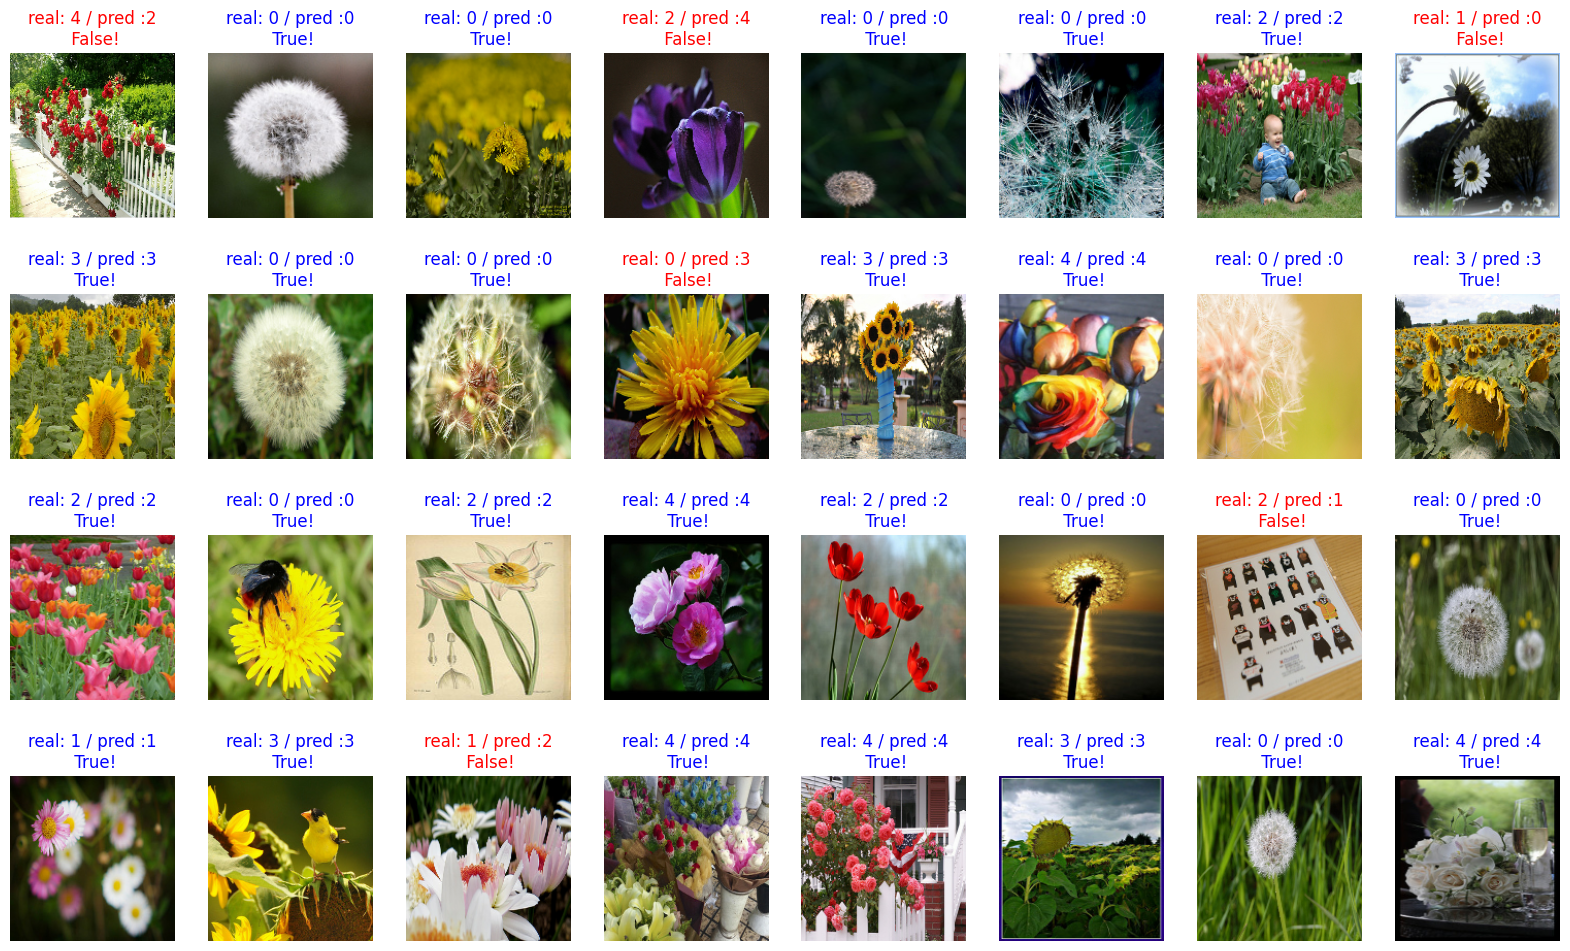

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count += 1

print(count / 32 * 100)

81.25


## Step 6. Model Usage


In [ ]:
# prompt: google drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted probabilities: [4.9579814e-03 9.7539574e-01 1.0890050e-03 1.8164804e-02 3.9247534e-04]
Predicted class: daisy (97.54%)


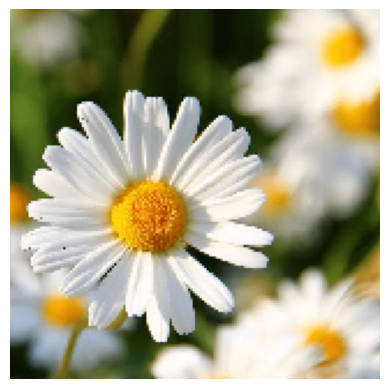

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def show_and_predict_image(model, filepath, img_size=160):
    # Load the image
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')

    # Convert to model input shape
    image_array = img_to_array(image)
    image_array = (image_array / 127.5) - 1.0
    image_array = tf.expand_dims(image_array, axis=0)

    # Predict
    predictions = model.predict(image_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_label = get_label_name(predicted_index)
    prediction_percentage = predictions[predicted_index] * 100

    print("Predicted probabilities:", predictions)
    print(f"Predicted class: {predicted_label} ({prediction_percentage:.2f}%)")

# Specify the path to any image you'd like to test.
sample_image_path = '/content/drive/MyDrive/datasets/flowers/daisy.jpg'
show_and_predict_image(model, sample_image_path)


# Step 7. Experiments

## EfficientNetB4 (lr=0.001, epoch=10)

In [ ]:
IMG_SIZE = 380

def format_example(image, label):
    # 이미지를 float32로 변환하고 [-1, 1] 구간으로 재조정
    # Convert image to float32 and scale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = train_data.map(format_example)
val = val_data.map(format_example)
test = test_data.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 샘플 확인
# Checking a sample batch
for image_batch, label_batch in train_batches.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 380, 380, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = tf.keras.applications.EfficientNetB4(
    input_shape=(380, 380, 3),
    include_top=False,
    weights='imagenet'
)

# Pretrained 모델의 학습을 동결 (Freeze the pretrained model)
base_model.trainable = False

# GlobalAveragePooling2D 레이어 준비
# Prepare the global average pooling layer
global_avg_layer = GlobalAveragePooling2D()

# 최종 분류 레이어 (tf_flowers는 5개 클래스)
# Final classification layer for 5 classes
prediction_layer = Dense(5, activation='softmax')

# 전체 모델 구성
# Build the full model
model = Sequential([
    base_model,
    global_avg_layer,
    Dense(512, activation='leaky_relu'),
    prediction_layer
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 12, 12, 1792)        │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,594,404 (70.93 MB)

 Trainable params: 920,581 (3.51 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(val_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - accuracy: 0.1471 - loss: 1.6716
initial loss: 1.68
initial accuracy: 0.15


In [ ]:

EPOCHS = 10

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 122s 781ms/step - accuracy: 0.2468 - loss: 1.7642 - val_accuracy: 0.3869 - val_loss: 1.4620
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3414 - loss: 1.5026

KeyboardInterrupt: 

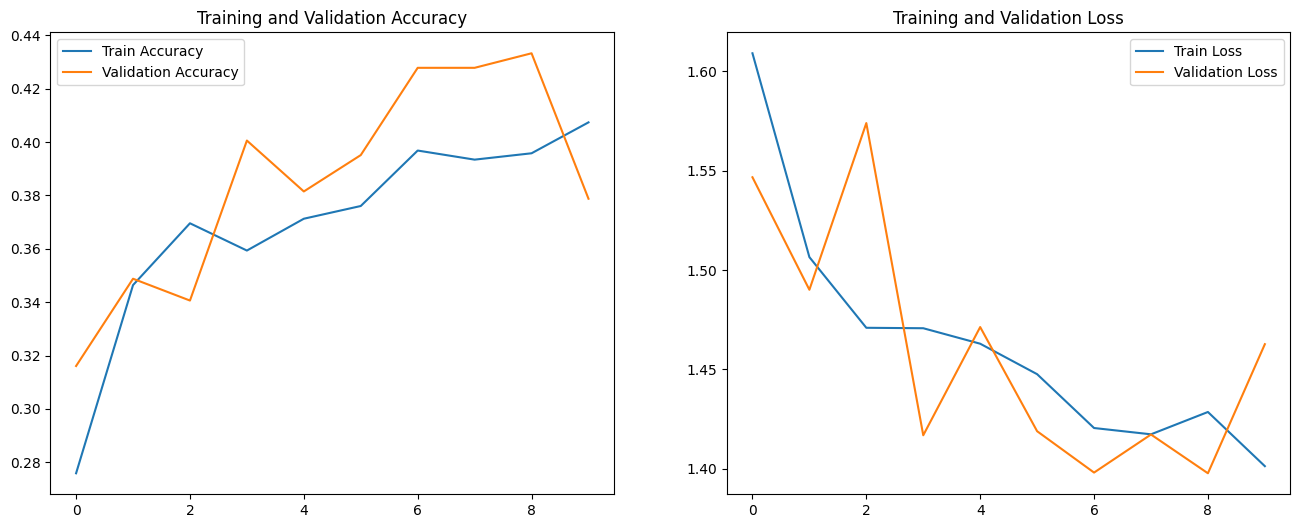

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3694 - loss: 1.4322
Test Loss: 1.4081, Test Accuracy: 0.3733


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


## MobileNetV3

In [ ]:
IMG_SIZE = 224

def format_example(image, label):
    # 이미지를 float32로 변환하고 [-1, 1] 구간으로 재조정
    # Convert image to float32 and scale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = train_data.map(format_example)
val = val_data.map(format_example)
test = test_data.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 샘플 확인
# Checking a sample batch
for image_batch, label_batch in train_batches.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

IMG_SIZE = 224  # MobileNetV3는 보통 224×224 권장
# MobileNetV3 typically uses 224x224 as its recommended input size

# MobileNetV3 Large를 base model로 사용
# Use MobileNetV3 Large as the base model
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=1.0,               # 모델 폭(width) 확장 비율 (1.0, 0.75 등 조정 가능)
    minimalistic=False,      # True면 더 간소화된 구조, False가 일반
    include_top=False,
    weights='imagenet'
)

# Pretrained 모델을 동결 (Freeze the pretrained model)
# Freeze the base model
base_model.trainable = False

# Global Average Pooling을 거쳐 최종 레이어 연결
# Apply GlobalAveragePooling and a final classification layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # 클래스 수에 맞춰 조정
])

# 모델 구조 요약
# Summarize the model structure
model.summary()

# 모델 컴파일
# Compile the model
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,490,949 (13.32 MB)

 Trainable params: 494,597 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:

EPOCHS = 10

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.3522 - loss: 1.4926 - val_accuracy: 0.4441 - val_loss: 1.3522
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4987 - loss: 1.2638 - val_accuracy: 0.4959 - val_loss: 1.2473
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5202 - loss: 1.2109 - val_accuracy: 0.4986 - val_loss: 1.2365
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5437 - loss: 1.1416 - val_accuracy: 0.4986 - val_loss: 1.2521
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5738 - loss: 1.0988 - val_accuracy: 0.5150 - val_loss: 1.1972
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5882 - loss: 1.0547 - val_accuracy: 0.5041 - val_loss: 1.2181
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6047 - loss: 1.0084 - val_accuracy: 0.4796 - val_loss: 1.2712
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6254 - loss: 0.9935 - val_accuracy: 0.5177 -

## InceptionResNetV2

In [ ]:
# 1) train_data, val_data, test_data 각각 크기 확인
print("Train data size:", len(list(train_data)))
print("Val data size:", len(list(val_data)))
print("Test data size:", len(list(test_data)))

# 2) 전처리 및 배치
BATCH_SIZE = 128

train = train_data.map(format_example).batch(BATCH_SIZE)
val = val_data.map(format_example).batch(BATCH_SIZE)
test = test_data.map(format_example).batch(BATCH_SIZE)

# 3) 샘플 확인
for image_batch, label_batch in train.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)

Train data size: 2936
Val data size: 367
Test data size: 367
Image batch shape: (128, 299, 299, 3)
Label batch shape: (128,)


In [3]:
IMG_SIZE = 299

def format_example(image, label):
    # 이미지를 float32로 변환하고 [-1, 1] 구간으로 재조정
    # Convert image to float32 and scale pixel values to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = train_data.map(format_example)
val = val_data.map(format_example)
test = test_data.map(format_example)

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 샘플 확인
# Checking a sample batch
for image_batch, label_batch in train_batches.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (128, 299, 299, 3)
Label batch shape: (128,)


In [4]:
IMG_SIZE = 299

with strategy.scope():
    base_model = tf.keras.applications.InceptionResNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze base model

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # Number of classes
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,126,245 (210.29 MB)

 Trainable params: 789,509 (3.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [6]:
EPOCHS = 15

history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=val
)


IndexError: list index out of range

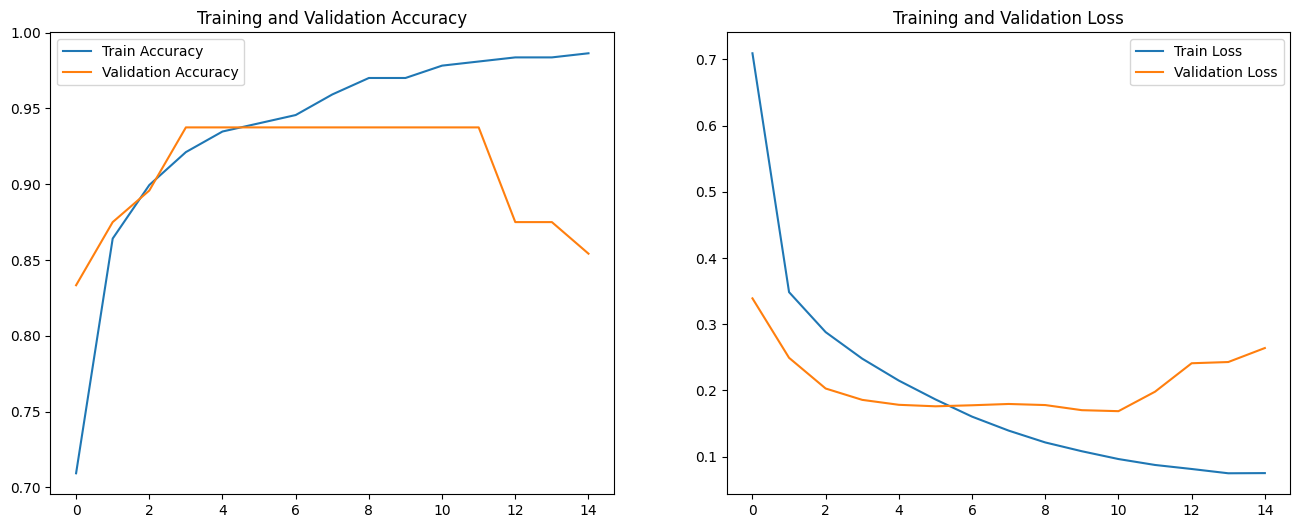

3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.1745 - loss: 1.5930
Test Loss: 1.5898, Test Accuracy: 0.2083


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


### InceptionResNetV2 + Data Aug + HP tuning

#### Data Aug + 전처리 함수

In [7]:
IMG_SIZE = 299
BATCH_SIZE = 128  # TPU 8코어 -> 실질적인 total batch=128 (각 코어당 16)

# 간단한 augmentation 레이어 구성
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 수평 뒤집기
    tf.keras.layers.RandomRotation(0.1),       # ±10% 범위 회전
    tf.keras.layers.RandomZoom(0.1),           # ±10% 범위 줌
])

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # [-1, 1] 스케일링
    image = (image / 127.5) - 1.0
    # 299×299 리사이즈
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Augmentation 적용
    image = augmentation(image)
    return image, label


In [8]:
train_ds = train_data.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


#### 초기 모델 정의 & 동결 학습

- with strategy.scope(): 안에서 모델 구성·컴파일
- Base Model: InceptionResNetV2 (include_top=False, weights='imagenet')
- GlobalAveragePooling2D → Dense(512, relu) → Dense(5, softmax)

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

with strategy.scope():
    base_model = tf.keras.applications.InceptionResNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # 모두 동결

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(5, activation='softmax')  # 클래스 개수에 맞춰 수정
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,126,245 (210.29 MB)

 Trainable params: 789,509 (3.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

#### 초기 학습(예: 5 Epoch만 먼저 학습)

In [10]:
print("==== Initial Training (all frozen) ====")
history_1 = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)


==== Initial Training (all frozen) ====
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.5705 - loss: 1.2688 - val_accuracy: 0.8125 - val_loss: 0.6730
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.7778 - loss: 0.6756 - val_accuracy: 0.8750 - val_loss: 0.4616
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.7919 - loss: 0.5360 - val_accuracy: 0.8750 - val_loss: 0.3660
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8456 - loss: 0.4976 - val_accuracy: 0.8750 - val_loss: 0.4019
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.8700 - loss: 0.4590 - val_accuracy: 0.9167 - val_loss: 0.3105


#### Fine-Tuning: 일부 레이어 언프리징 (상단 20개 가정)

- 상단 일부 레이어(예: 20개)만 unfreeze
- 일반적으로 learning rate를 조금 더 낮춰서 fine-tuning
- ReduceLROnPlateau나 EarlyStopping 콜백을 함께 사용하면 더 안정적

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 콜백 구성
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

fine_tune_at = len(base_model.layers) - 20  # 맨 위 20개 레이어만 학습
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

print("==== Fine-Tuning (top 20 layers) ====")
history_2 = model.fit(
    train_ds,
    epochs=15,  # 필요시 더 늘려도 좋음
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr]
)


==== Fine-Tuning (top 20 layers) ====
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8082 - loss: 0.5662 - val_accuracy: 0.8542 - val_loss: 0.3239 - learning_rate: 0.0010
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8726 - loss: 0.3921 - val_accuracy: 0.8542 - val_loss: 0.2485 - learning_rate: 0.0010
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8943 - loss: 0.3187 - val_accuracy: 0.9375 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9017 - loss: 0.2794 - val_accuracy: 0.9583 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9368 - loss: 0.2188 - val_accuracy: 0.9792 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9427 - loss: 0.2006 - val_accuracy: 0.9792 - val_loss: 0.1005 - learning_rate: 0.0010
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy:

In [12]:
model.save('flower_classifier_v1.h5')

In [19]:
import os
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /content


In [20]:
!ls /content

flower_classifier_v1.h5  sample_data


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!ls /content/drive/MyDrive

'Colab Notebooks'


In [24]:
model.save('/content/drive/MyDrive/flower_classifier_v1.h5')

In [25]:
!ls /content/drive/MyDrive

'Colab Notebooks'   flower_classifier_v1.h5


In [14]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)

# plt.figure(figsize=(16, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Train Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Train Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9375 - loss: 0.2459
Test Loss: 0.2056, Test Accuracy: 0.9375


# 최종 [ Test Loss: 0.1346 ] [ Test Accuracy: 0.9583 ] 달성

In [15]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step


array([[1.34335235e-01, 6.57598749e-02, 2.38807827e-01, 2.42001086e-01,
        3.19096059e-01],
       [9.99582589e-01, 3.57474259e-04, 2.58288787e-06, 5.30346224e-05,
        4.29566353e-06],
       [7.30783224e-01, 7.57047848e-04, 1.90053054e-03, 2.66388446e-01,
        1.70787825e-04],
       [2.81568384e-04, 2.87218904e-03, 9.21195745e-01, 2.27078941e-04,
        7.54234567e-02],
       [9.99913573e-01, 6.50885559e-05, 9.30632086e-06, 9.51810034e-06,
        2.49108280e-06],
       [9.99945283e-01, 3.07821829e-05, 2.79464189e-06, 1.69524992e-05,
        4.27637178e-06],
       [1.41210146e-02, 2.76998710e-02, 9.49519098e-01, 7.95201305e-03,
        7.08059932e-04],
       [1.18527096e-02, 6.58367202e-02, 5.41917302e-07, 9.22305822e-01,
        4.14557189e-06],
       [2.54100189e-04, 1.02193153e-05, 3.59153410e-06, 9.99730289e-01,
        1.82812573e-06],
       [9.99975204e-01, 8.59857573e-06, 2.64454957e-06, 1.29022674e-05,
        7.51852667e-07],
       [9.99927878e-01, 4.5147

In [16]:
import numpy as np

predictions = np.argmax(predictions, axis=1)
predictions

array([4, 0, 0, 2, 0, 0, 2, 3, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       0, 0, 1, 3, 1, 2, 4, 3, 0, 4, 4, 4, 2, 1, 4, 0, 0, 3, 4, 3, 3, 2,
       1, 1, 0, 0, 4, 2, 4, 1, 4, 1, 1, 2, 4, 4, 1, 0, 4, 3, 3, 1, 0, 0,
       3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3, 2, 2,
       2, 1, 2, 0, 1, 1, 3, 3, 3, 3, 2, 0, 3, 2, 4, 4, 2, 0, 3, 2, 2, 1,
       2, 4, 2, 1, 4, 0, 4, 0, 1, 2, 2, 1, 4, 2, 2, 2, 3, 0])

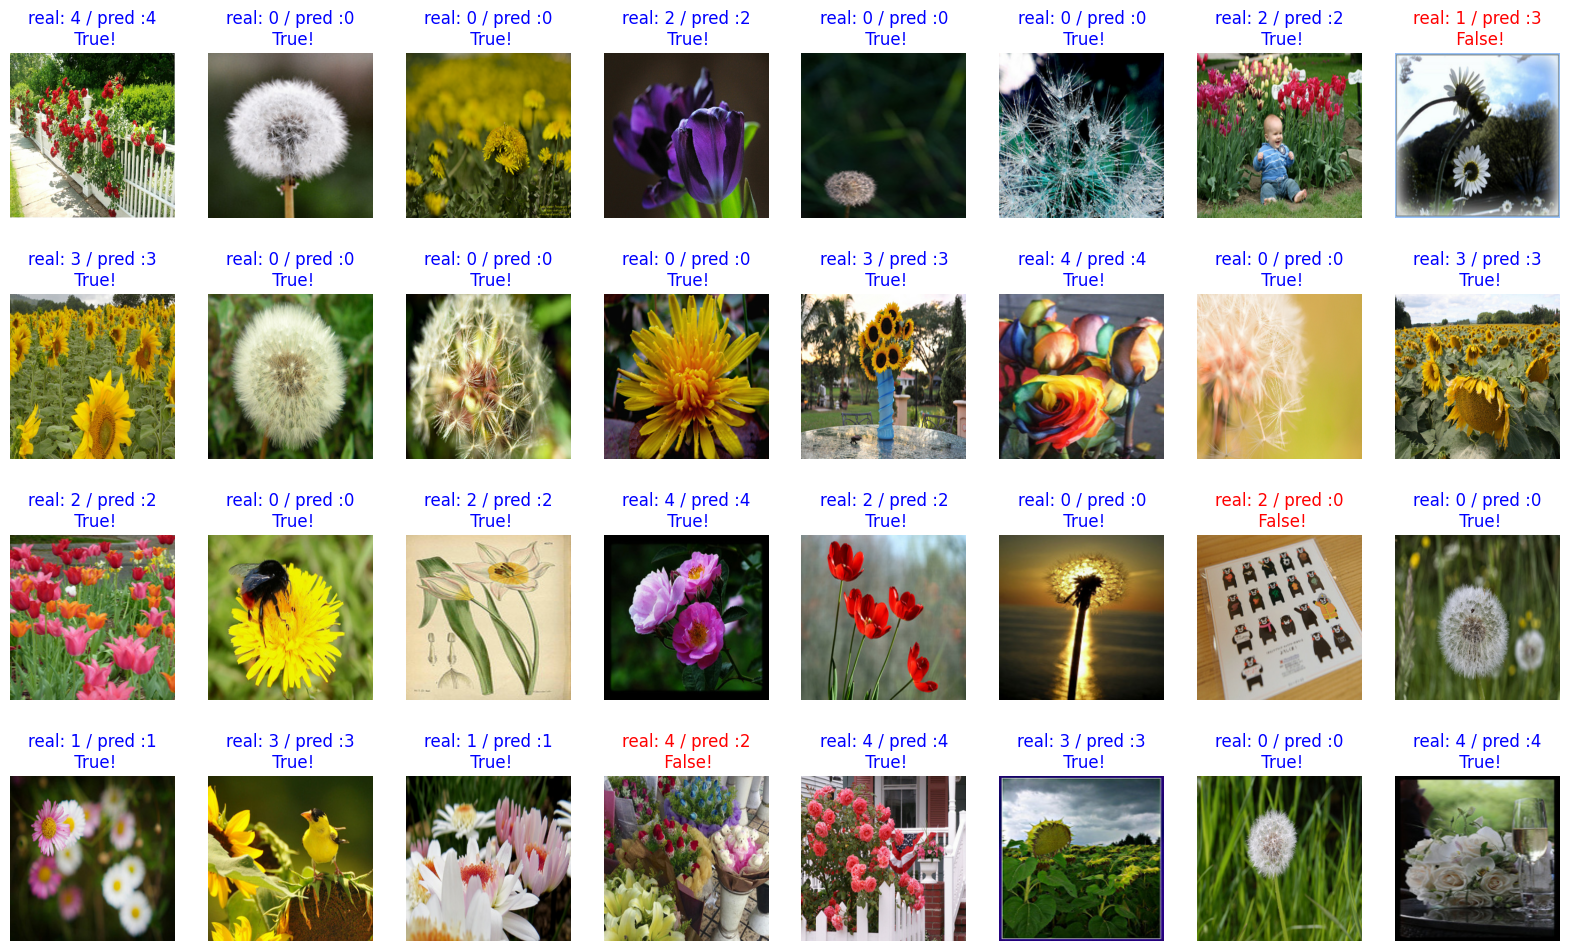

In [17]:
plt.figure(figsize=(20, 12))

# Limit the loop to the number of subplots available
for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    if idx >= 32:  # Stop if idx exceeds the subplot grid size
        break
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [18]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count += 1

print(count / 128 * 100)

89.84375


# 회고

##### 모델 선정이유.
- vgg 대비 경량 모델의 성능을 비교하고자 efficientNet과 mobilenet 등을 시도하였고 제한된 리소스의 한계
- 환경 개선을 위해 새로운 TPU 환경을 구축하고 성능 중심의 모델 InceptionResNetV2 pretrained model 적용. Test 기준 82%를 상회
- 이어서 데이터 증강과 파인튜닝을 통해 95.8%까지 성능 재고



##### 하이퍼파라미터 선정 이유
1. TPU 연결 → 전략 생성 (strategy = tf.distribute.TPUStrategy(tpu))
2. with strategy.scope(): 내부에서 InceptionResNetV2 기반 모델 정의 & 컴파일
3. Batch Size=128으로 .batch(128) 적용한 train_ds, val_ds 구성
4. 초기 학습(전체 동결) → Fine-Tuning(상단 일부 언프리징)
5. Data Augmentation(RandomFlip, RandomRotation, RandomZoom)으로 일반화 성능 향상
6. 콜백(EarlyStopping, ReduceLROnPlateau)으로 학습률과 조기 종료 제어
- Vit 비교 실험 : 기본적으로 CNN 과 접근자체가 다른 아키텍쳐 개념이며 전체 고딩을 새롭게 구성해야 함. 굉장히 파워풀 성능을 wandb sweep 과 함께 확인



##### 데이터 전처리 이유 : [-1, 1] 범위로 정규화하는 이유
 일반적으로 [0,1] 또는 [−1,1]로 정규화하는데
[−1,1]로 정규화하는 이유는 ReLU, LeakyReLU 같은 비선형 활성화 함수는 0을 기준으로 좌우 대칭인 입력 데이터에서 더 빠르게 수렴하는 경향 있음.  
특히 TPU와 GPU에서의 병렬 연산 성능이 정규화된 입력값에 의해 더 효과적으로 발휘될 수 있음.  
데이터가 음수 값을 포함할 경우 균형 잡힌 가중치 업데이트가 가능


##### 배운 점
- 각 모델의 최적의 호환 imgage size가 존재
- EfficientNet B4 = 380 , InceptionResNetV2 =299 등등
- 파인튜닝 과정
1. 초기학습(epoch=5) 동안에는 사전학습(Pretrained) 모델을 완전히 동결시키고 새로운 Dense 레이어만 학습하도록 하는 방식  
2. 이후 어느 정도 기본 학습이 진행된 뒤, 상단 20개 레이어만 언프리징하고 최상위 레이어 부분만 다시 학습(파인튜닝)  
3. 처음부터 모든 레이어를 학습시키면 가중치가 급변해 학습이 불안정해질 수 있다.  
초기에는 새로 붙인 분류 레이어가 데이터셋 특성에 맞게 빠르게 적응하도록 동결된 상태로 학습  
이미 ImageNet(혹은 다른 대규모 데이터셋)으로 학습된 가중치 정보를 최대한 보존하고 하위 레이어는 일반적으로 더욱 기초적인 특징(엣지, 텍스처 등)을 추출하므로 Top Layer만 미세 조정  
 *InceptionResNetV2의 총 레이어는 780개



##### 아쉬운 점
- 새로운 옵티마이저에 대한 비교 실험(시간상)
- AdamW  
특징: Adam에 Weight Decay 방식을 좀 더 정교하게 적용한 개선판.  
장점: Addresses Adam’s tendency to overfit by decoupling weight decay from gradient updates, often improving generalization.  
주의할 점: 별도의 weight_decay 하이퍼파라미터 설정이 필요.
- wandb artifacts를 통한 버전관리 방식을 튜터리얼 중이나 flower에서는 적용하지 못했다.  



##### 느낀 점
1. 현재 결과가 의미하는 것  
  95.83%의 정확도는 일반적으로 큰 데이터셋(예: tf_flowers)에서 매우 우수한 성능을 의미  
Test Loss가 낮다는 것은 모델이 거의 모든 테스트 샘플에서 정확한 분류를 했음을 나타내며, overfitting이 크게 없을 가능성이 높다.
  
2. 추가 성능 향상이 필요할 때
지금 성능에 만족하셔도 좋지만, **더 높은 정확도(97% 이상)**를 목표로 한다면 아래를 고려할 수 있다:

  (1) Fine-Tuning 레이어 확장  
상단 20개에서 상단 30개~50개로 언프리징 범위를 늘려 더 정밀한 미세 조정을 시도
```
fine_tune_at = len(base_model.layers) - 30  # 30개 레이어 언프리징
```
(2) 데이터 증강 강화  
기존의 RandomFlip, RandomRotation, RandomZoom 외에 brightness나 contrast 조정을 추가하면 더 일반화된 모델을 만들 수 있다.    
```
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2),  # 밝기/대비 추가
    ])
```

 (3) Learning Rate Schedule  
  ReduceLROnPlateau 콜백 외에도 Cosine Decay나 Polynomial Decay와 같은 학습률 스케줄링을 고려    
```
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    alpha=0.01
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  
```    
(4) Larger Models  
현재 InceptionResNetV2를 사용했지만, NASNetLarge나 EfficientNetV2-Large 같은 모델로 변경하면 더 높은 성능을 기대할 수 있다.  
```
base_model = tf.keras.applications.NASNetLarge(
    input_shape=(331, 331, 3),
    include_top=False,
    weights='imagenet'
)
```


3. 마무리   
 95.83% 정확도 달성은 이미 상당히 높은 수준이며, 개인적으로 매우 유의미한 실험 경험이 되었다. 현 데이터셋에서 더 높은 성능은 미세 조정(Fine-Tuning)이나 데이터 증강 강화를 통해 가능하고 새로운 데이터셋에서 적용하고자 한다면, 지금의 설정을 모듈로 이어갈 수 있겠다.




##### 어려웠던 점
- 언제나 학습환경 리소스의 제약이 원할한 실험에 도전요소